## [Using virtual enviroments in jupyter on longleaf](https://help.rc.unc.edu/python-packages/#using-virtual-environments-in-a-jupyter-notebook)


I ran that command for `py310` and `base` conda environments

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../epsampling/')

import random
import numpy as np
import pandas as pd
import os
import csv
from tqdm import tqdm
 
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})
    
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', None)

from datetime import datetime

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio
def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [2]:
import torch

timestamp = '20241029-123405'
fpath = os.path.join(DATA_DIR,'cached', f'df_modeling_pastweeks_{timestamp}.csv')

df = pd.read_csv(fpath)

## add dummy state variable
df_fips = pd.read_csv('state_fips.csv')
fips_to_st = {k:v for k,v in zip(df_fips.Fips, df_fips.Postal)}
dummies = pd.get_dummies(df['State_fips']).rename(columns=lambda x: 'Is_' + fips_to_st[x]  )
df = pd.concat([df, dummies], axis=1)
df.drop(['State_fips'], inplace=True, axis=1)

df.dropna(inplace=True)

## remove outliers
from scipy import stats
df = df[np.abs(stats.zscore(df.Target)) < 5]

# # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # #
df = df.sample(100000)
# # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # #

## separate X and y
not_feats = ['Target','Fips', 'State_fips', 'Date',
             'Proj_inc_deaths', 'True_cum_deaths', 'Cum_deaths_tm1',
             'True_inc_deaths', 'Naive_inc_deaths','Target']
feats = [x for x in df.columns if x not in not_feats]
df_X = df[feats]
# .values.astype('float32')
df_y = df['Target']

# .values.astype('float32')

# standardize X
# df_X = (df_X-df_X.mean()) / df_X.std()

_df_X = df_X.loc[:, df_X.columns != 'Naive']
_df_X = (_df_X-_df_X.mean()) / _df_X.std()
_df_X['Naive'] = df_X['Naive']
df_X = _df_X



#     X_arr = df[feat_cols].values.astype('float32')
#     y_arr = df[target_col].values.astype('float32')
#     X = torch.tensor(X_arr)
#     y = torch.tensor(y_arr).reshape(-1, 1)

# Random split
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.1, 
                                                      random_state=666, shuffle=True)

X_test = torch.tensor( df_test.values.astype('float32'))
y_test = torch.tensor( y_test.values.astype('float32')).reshape(-1, 1)
X_train = torch.tensor( df_train.values.astype('float32'))
y_train = torch.tensor( y_train.values.astype('float32')).reshape(-1, 1)

In [3]:
import torch.utils.data as data_utils

def get_loader(X, y,  bs=32):
    
#     if isinstance(X, pd.DataFrame):
#     X = X.values.astype('float32')
#     else:
#         X = X.astype('float32')
#     y = y.values.astype('float32')
#     X = torch.tensor(X)
#     y = torch.tensor(y).reshape(-1, 1)
    
    dataset = data_utils.TensorDataset(X, y)
    loader = data_utils.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)
    
    return loader   

In [4]:
import torch.nn as nn
import torch.optim as optim

num_feats = len(feats)
print(num_feats)


import torch
import torch.nn as nn
import torch.nn.functional as F
class EpModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.l0 = nn.Linear(num_feats, 128)
        self.l1 = nn.Linear(128, 64)
        self.l2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.l0( x ))
        x = self.relu(self.l1( x ))
        x = self.relu(self.l2( x ))
#         x = self.relu(self.out( x ))
        x = self.out( x )
        
        
        return x

115


  0%|          | 0/100 [00:00<?, ?it/s]

12.263562202453613 11.897225379943848
3.6018590927124023 3.532987594604492
3.4771504402160645 3.418348550796509
3.3895537853240967 3.3355159759521484
3.351010799407959 3.3015449047088623
3.333509683609009 3.283677339553833
3.3172247409820557 3.2713634967803955
3.3044118881225586 3.258622169494629
3.29658579826355 3.250943660736084
3.2872419357299805 3.2447845935821533
MSE: 3.24
RMSE: 1.80


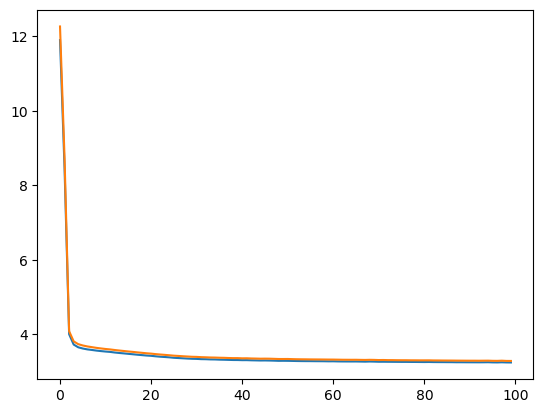

In [19]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
n_epochs = 100  
bs = 1024
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
test_history = []
train_history = []

model = EpModel()
loss_fn = nn.MSELoss()  # mean square error
loss_fn = nn.L1Loss()  # mean square error

optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in tqdm(range(n_epochs)):
    model.train()
    
    loader = get_loader(X_train, y_train, bs=bs)
    for X_batch, y_batch in loader:
    
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    

    y_pred = model(X_train)
    train_mse = float(loss_fn(y_pred, y_train))
    train_history.append(train_mse) 
    
    y_pred = model(X_test)
    test_mse = float(loss_fn(y_pred, y_test))
    test_history.append(test_mse)
    
    
    if test_mse < best_mse:
        best_mse = test_mse
        best_weights = copy.deepcopy(model.state_dict()) 
        
    if epoch % 10==0: print(train_mse, test_mse)
            
# model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(test_history)
plt.plot(train_history)
# plt.yscale('log')
plt.show()            


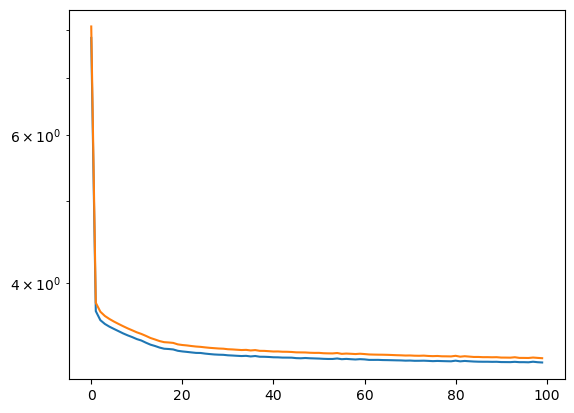

In [13]:
plt.plot(test_history)
plt.plot(train_history)
plt.yscale('log')
plt.show()   

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
def get_performance(model_names, model_preds, y_test):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score,
                   }

    model_res_dict = {model:{} for model in model_names}
    
    for model,pred in zip(model_names, model_preds):
        for metric, func in metrics_dict.items():
            if metric=='RMSE':
                model_res_dict[model][metric] = func(y_test, pred, squared=False)
            else:
                model_res_dict[model][metric] = func(y_test, pred)
            
    return model_res_dict


metrics_dict = get_performance(['MLP','Naive'], 
                               [model(X_test).detach().numpy(), df_test['Naive'].values], 
                               y_test)
display(metrics_dict)

metrics_dict = get_performance(['MLP','Naive'], 
                               [model(X_train).detach().numpy(), df_train['Naive'].values], 
                               y_train)
display(metrics_dict)


{'MLP': {'MAE': 3.2175398,
  'MedAE': 0.72911197,
  'MSE': 76.00071,
  'RMSE': 8.717838,
  'r2': 0.788481398878053},
 'Naive': {'MAE': 3.7230959577470903,
  'MedAE': 1.7565994596301926,
  'MSE': 70.63835780193152,
  'RMSE': 8.404662860694147,
  'r2': 0.8034054177171669}}

{'MLP': {'MAE': 3.2553868,
  'MedAE': 0.71638,
  'MSE': 72.161,
  'RMSE': 8.494763,
  'r2': 0.8106343706394662},
 'Naive': {'MAE': 3.808764297744334,
  'MedAE': 1.8200061325514147,
  'MSE': 67.74125323546593,
  'RMSE': 8.230507471320704,
  'r2': 0.8222327032889376}}

In [15]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# np.set_printoptions(suppress=True)

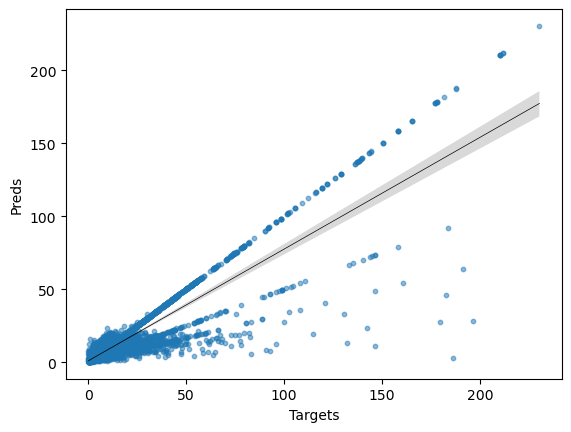

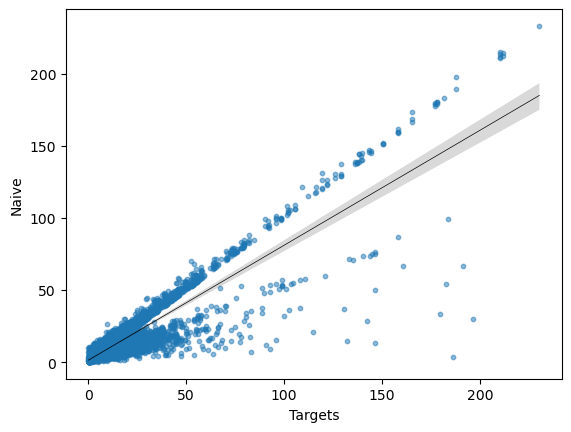

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


preds = np.squeeze(model(X_test).detach().numpy())
trues = np.squeeze(y_test.detach().numpy())
res_df = pd.DataFrame(list(zip(preds, trues )), columns=['Preds','Targets'])

sns.regplot(data=res_df, x='Targets', y='Preds', 
            scatter_kws={'s':10, 'alpha':0.5}, 
            line_kws={'color':'k','linewidth':0.5},logx=False)

plt.show()


preds = df_test['Naive'].values
trues = np.squeeze(y_test.detach().numpy())
res_df = pd.DataFrame(list(zip(preds, trues )), columns=['Naive','Targets'])

sns.regplot(data=res_df, x='Targets', y='Naive', 
            scatter_kws={'s':10, 'alpha':0.5}, 
            line_kws={'color':'k','linewidth':0.5},logx=False)

plt.show()

In [10]:
res_df

,Naive,Targets
0,6.326977,11.710287
1,17.088933,14.376079
2,37.788395,108.147079
3,11.042447,10.427528
4,63.010500,57.937428
...,...,...
9995,3.581619,3.711333
9996,1.331233,1.559722
9997,8.452695,5.500247
9998,3.732688,3.198633


In [11]:
np.squeeze(model(X_test).detach().numpy())

array([5.835458, 14.596712, 36.059063, ..., 8.816794, 4.833915, 29.516943],
      dtype=float32)

In [12]:
df_test['Naive'].values

array([6.326977, 17.088933, 37.788395, ..., 8.452695, 3.732688, 30.032420])